Visualising the Great British Bakeoff with [#TidyTuesday](https://twitter.com/hashtag/TidyTuesday) | [source](https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-10-25/https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-10-25/).

We follow the examples given in [Data Visualization in the Tidyverse - The Great Tidy Plot Off](https://alison.netlify.app/uo-tidy-bakeoff/#1) by Alison Hill.

## Dependencies

In [1]:
import pandas as pd
from seaborn import objects as so
from matplotlib import style
import lrdataio

In [2]:
%load_ext watermark
%watermark -iv

seaborn   : 0.12.1
pandas    : 1.4.4
lrdataio  : 0.3.0
matplotlib: 3.6.0



## Cache and load the data

In [3]:
ratings_df = pd.read_csv(lrdataio.cache_url('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-10-25/ratings.csv'))  # noqa
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   series                94 non-null     int64  
 1   episode               94 non-null     int64  
 2   uk_airdate            94 non-null     object 
 3   viewers_7day          94 non-null     float64
 4   viewers_28day         93 non-null     float64
 5   network_rank          70 non-null     float64
 6   channels_rank         50 non-null     float64
 7   bbc_iplayer_requests  20 non-null     float64
 8   episode_count         94 non-null     int64  
 9   us_season             50 non-null     float64
 10  us_airdate            45 non-null     object 
dtypes: float64(6), int64(3), object(2)
memory usage: 8.2+ KB


## How has the viewership changed?

### `series8_decline`

In [4]:
series8_decline = (
    ratings_df
    .query('1 <= series <= 8')
    .assign(series=lambda x: x['series'].astype(str))
)

### Continuous bar chart

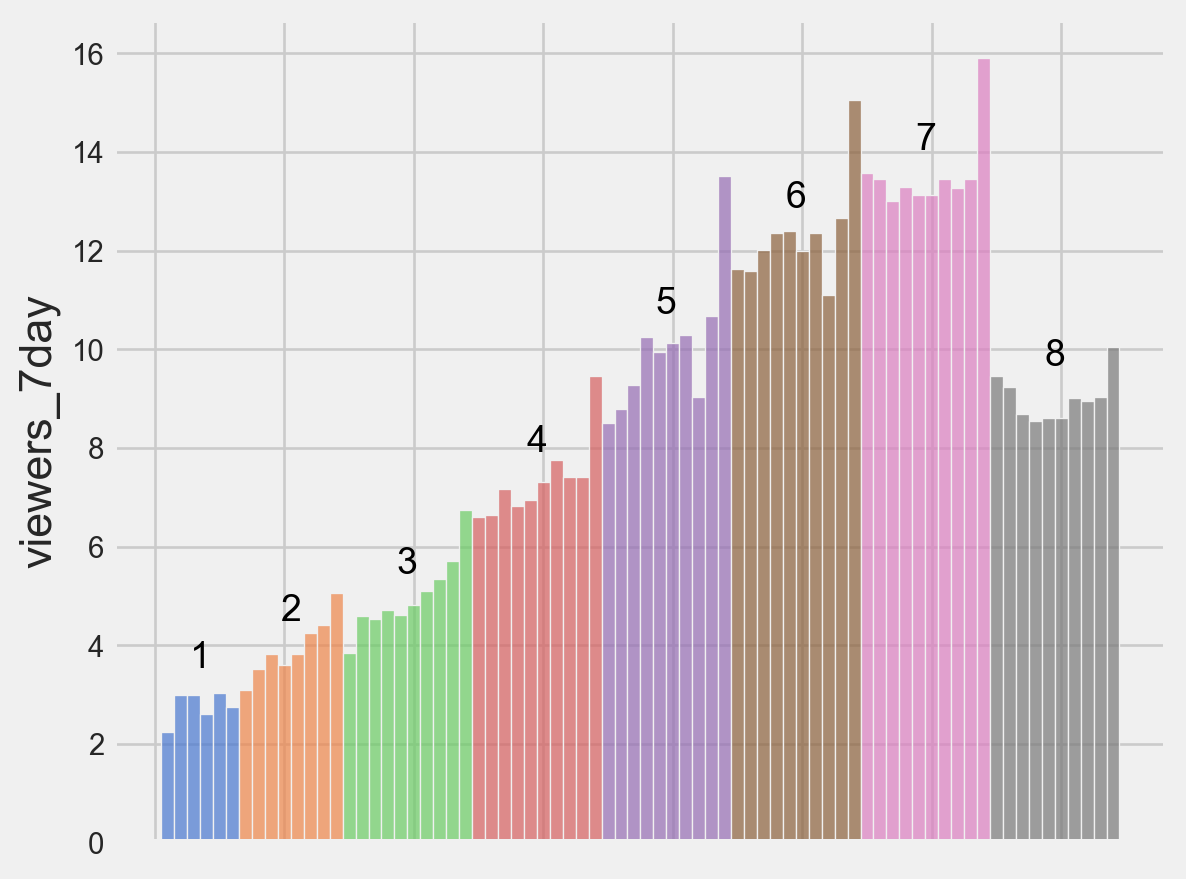

In [5]:
#| code-fold: true
def _plot_cts_bar_chart(df: pd.DataFrame) -> None:
    series_text = (
        pd.DataFrame()
        .assign(
            episode_count=df.groupby('series')['episode_count'].mean(),
            viewers_7day=df.groupby('series')['viewers_7day'].median()
        )
        .reset_index()
    )
    return (
        so.Plot(df,
                x='episode_count',
                y='viewers_7day',
                color='series',
                text='series')
        .add(so.Bars(), legend=False)
        .add(so.Text(color='black',
                     valign='bottom',
                     offset=10),
             data=series_text)
        .scale(x=so.Continuous().label(like=lambda _, __: ''), color='muted')
        .label(x='')
        .theme({**style.library["fivethirtyeight"]})
    )


series8_decline.pipe(_plot_cts_bar_chart)

### Faceted line chart

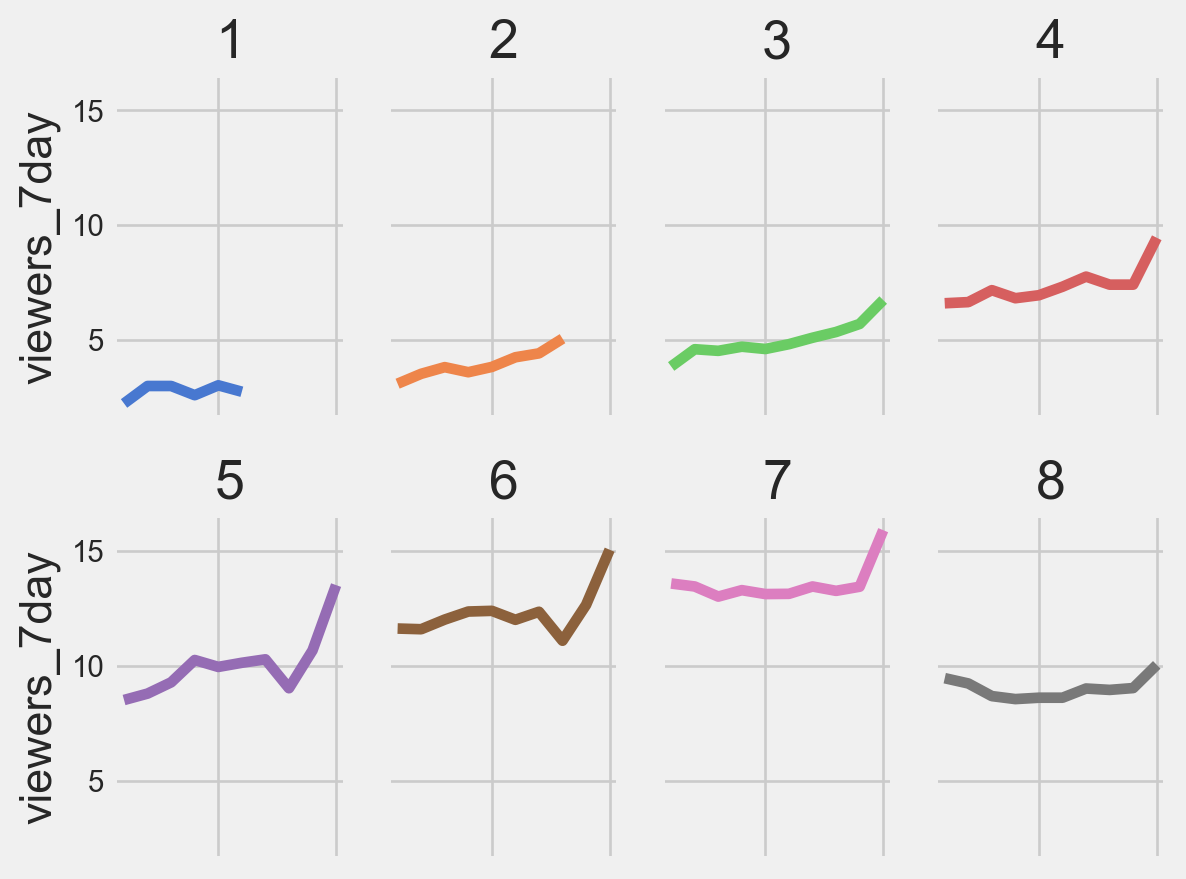

In [6]:
#| code-fold: true
def _plot_faceted_line_chart(df: pd.DataFrame) -> None:
    return (
        so.Plot(df,
                x='episode',
                y='viewers_7day',
                color='series')
        .add(so.Line(), legend=False)
        .scale(x=so.Continuous().label(like=lambda _, __: ''),
               color='muted')
        .facet(col='series', wrap=4)
        .label(x='')
        .theme({**style.library["fivethirtyeight"]})
    )


series8_decline.pipe(_plot_faceted_line_chart)

## Premieres vs. Finales

### `first_last`

In [7]:
first = ratings_df.query('episode == 1 and (1 <= series <= 8)')
last = (
    ratings_df
    .query('1 <= series <= 8')
    .sort_values(by=['episode', 'series'],
                 ascending=[False, True])
    .drop_duplicates('series')
)
first_last = (
    pd.concat([first, last])
    .assign(episode=lambda x: x['episode'].apply(
                lambda s: ('first' if s == 1 else 'last')),
            series=lambda x: x['series'].astype(str))
)

### `finale_pct_bump`

In [8]:
finale_pct_bump = (
    first_last
    .set_index('series')
    .groupby('series')['viewers_7day'].pct_change()
    .rename('prop_bump')
    .dropna()
    .to_frame()
    .assign(pct_bump=lambda x: (x['prop_bump'] * 100).round(1))
    .sort_index(ascending=False)
)

### Dumbbell plot

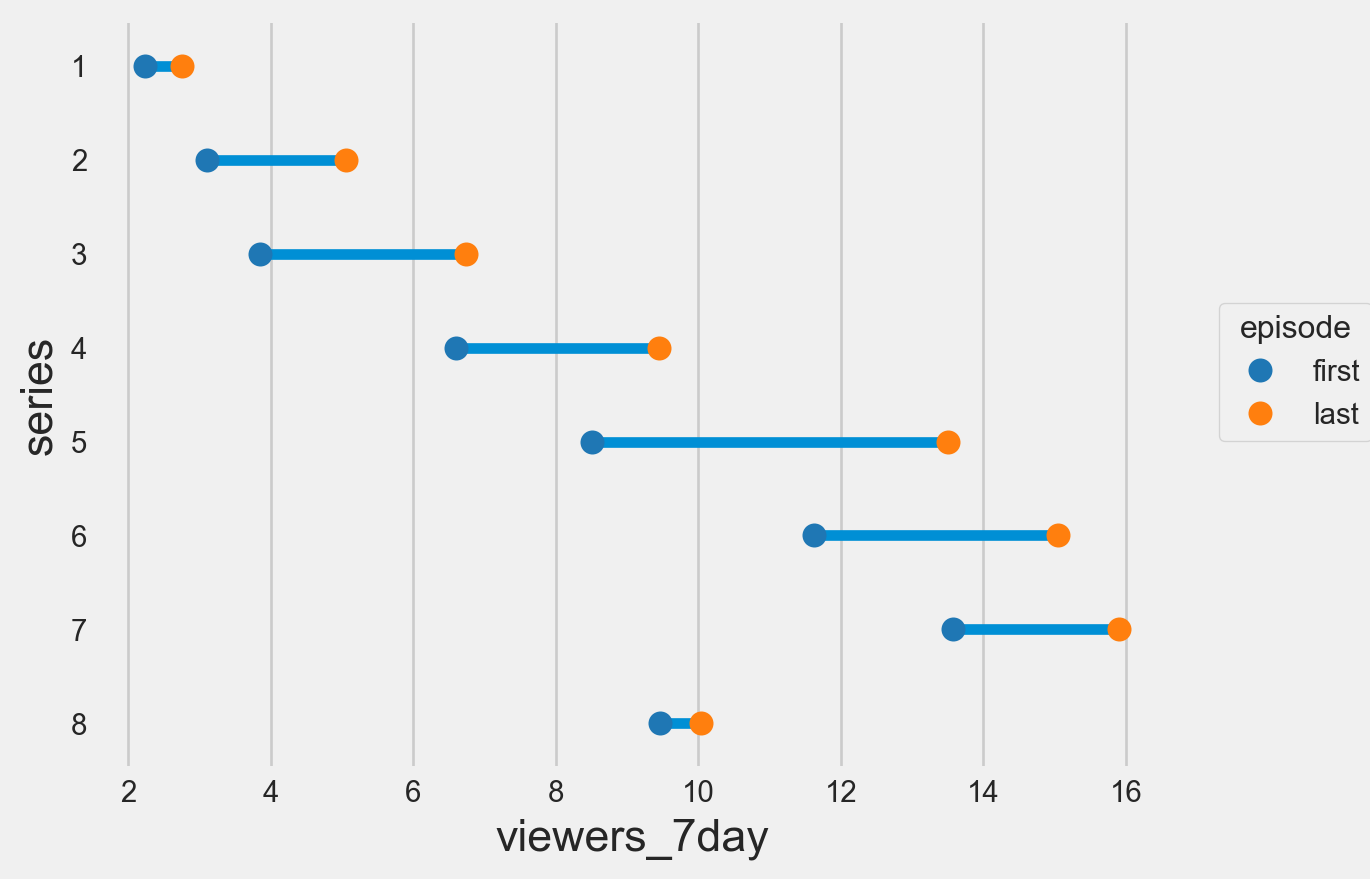

In [9]:
#| code-fold: true
def _plot_dumbbell(df) -> so.Plot:
    return (
        so.Plot(df,
                x='viewers_7day',
                y='series',
                group='series',
                text='series')
        .add(so.Line(), legend=None)
        .add(so.Line(linewidth=0, marker='o', pointsize=8),
             color='episode',
             data=df)
        .scale(color='tab10')
        .theme({**style.library["fivethirtyeight"]})
    )


first_last.pipe(_plot_dumbbell)

### Slope graph

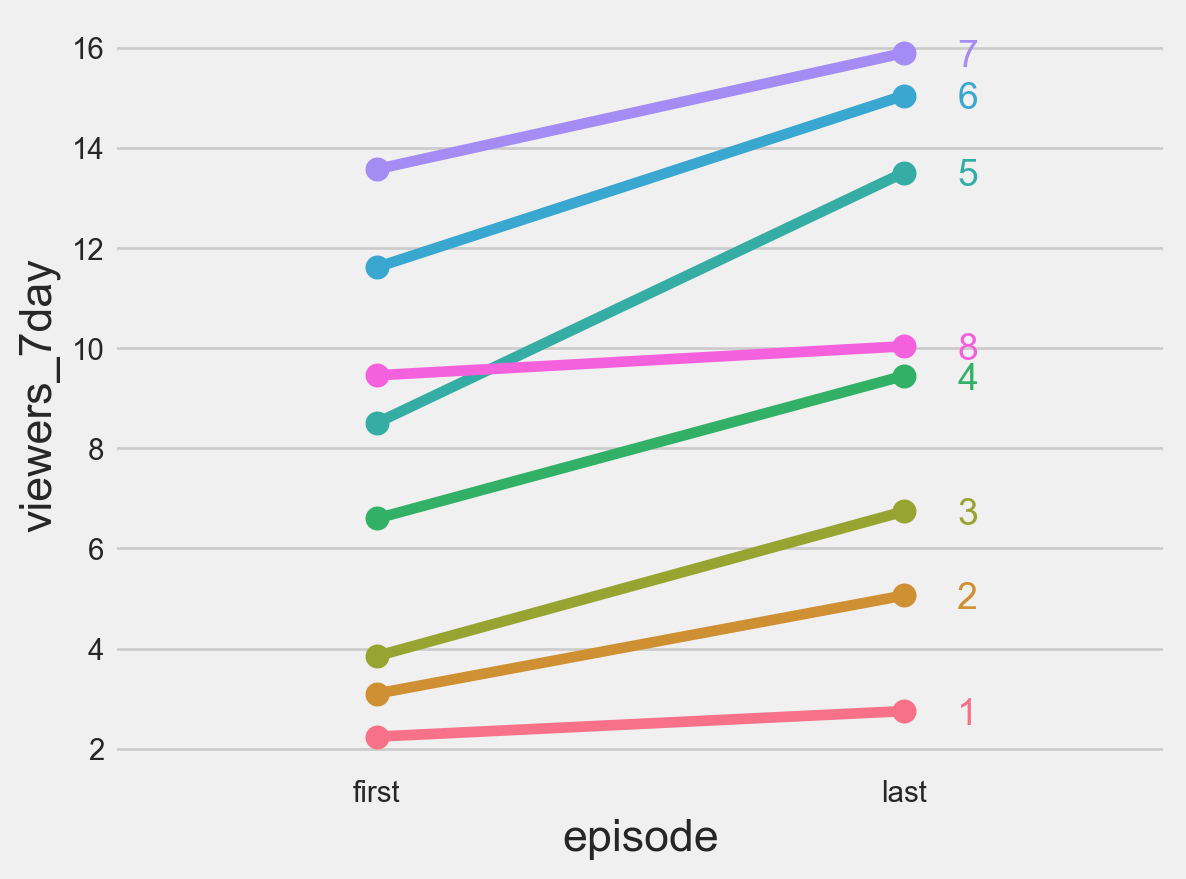

In [10]:
#| code-fold: true
def _plot_slope(df) -> so.Plot:
    return (
        so.Plot(df,
                x='episode',
                y='viewers_7day',
                color='series',
                text='series')
        .add(so.Line(marker='o',
                     pointsize=8),
             legend=None)
        .add(so.Text(halign="left",
                     offset=20),
             data=df.query('episode == "last"'))
        .theme({**style.library["fivethirtyeight"]})
    )


first_last.pipe(_plot_slope)

### Bar chart with median line

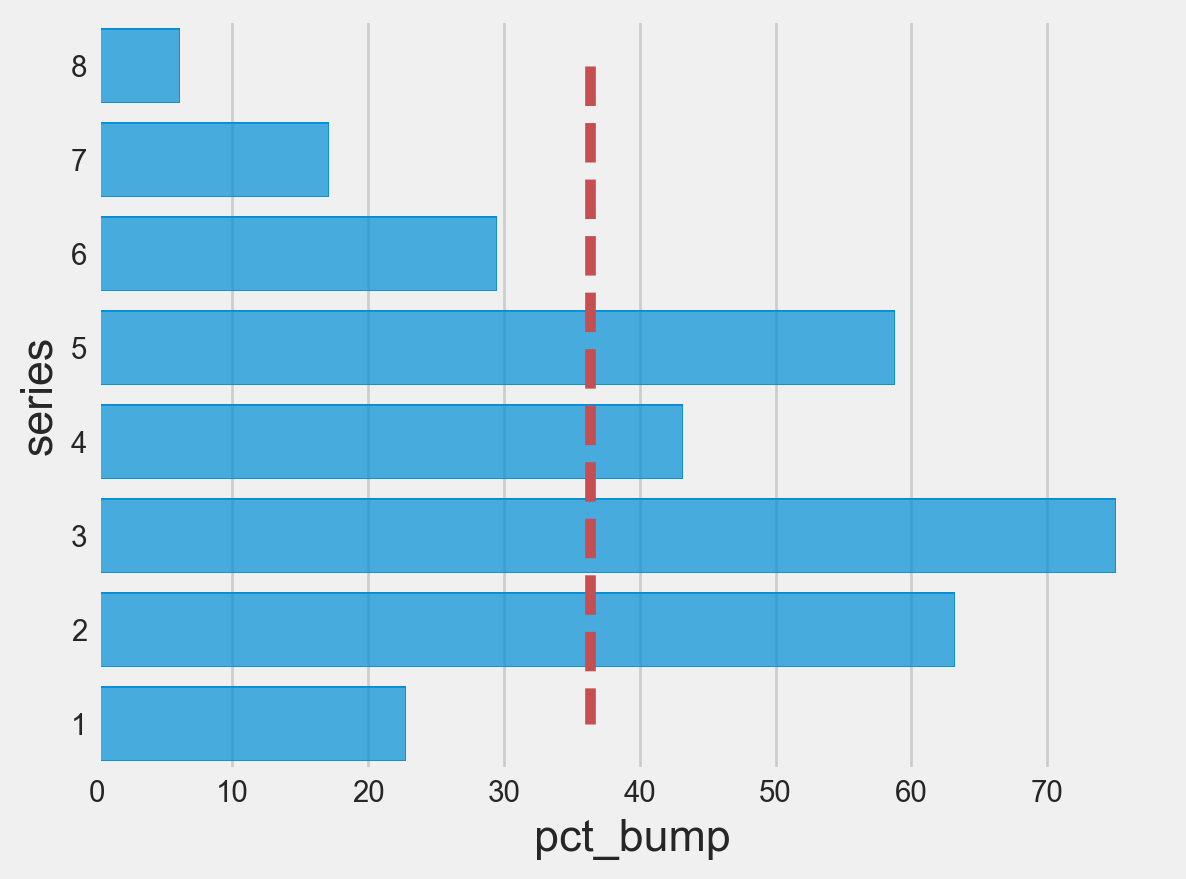

In [11]:
#| code-fold: true
def _plot_bar_hax_line(df) -> so.Plot:
    med_line = df.assign(pct_bump=[df['pct_bump'].median()] * 8)
    return (
        so.Plot(df, x='pct_bump', y='series')
        .add(so.Bar(),
             orient='h')
        .add(so.Line(color='r',
                     linestyle='dashed'),
             data=med_line,
             orient='h')
        .theme({**style.library["fivethirtyeight"]})
    )


finale_pct_bump.pipe(_plot_bar_hax_line)

### Lollipop chart with median line

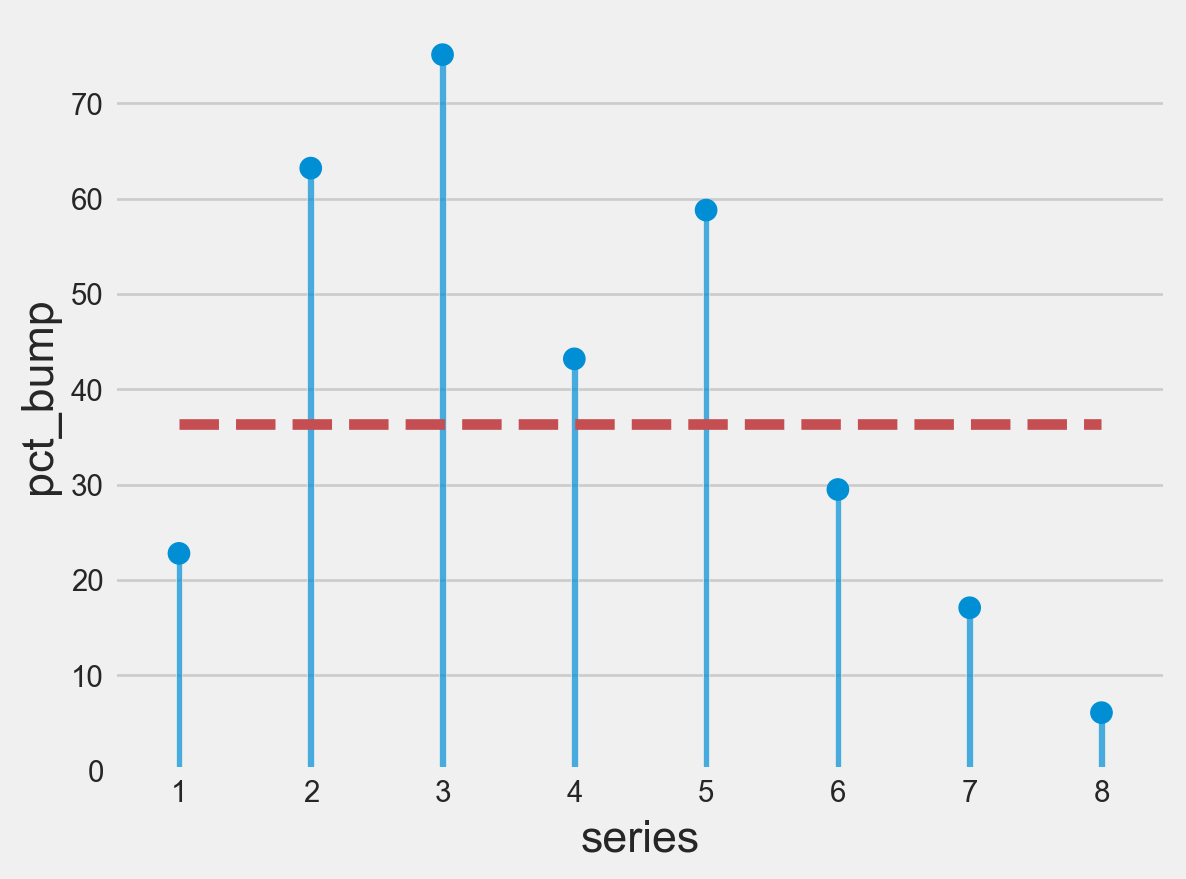

In [12]:
#| code-fold: true
def _plot_lollipop_hax_line(df) -> so.Plot:
    df = df.sort_index()
    med_line = df.assign(pct_bump=[df['pct_bump'].median()] * 8)
    return (
        so.Plot(df,
                x='series',
                y='pct_bump')
        .add(so.Bars(width=0.05))
        .add(so.Dot(pointsize=8))
        .add(so.Line(color='r',
                     linestyle='dashed'),
             data=med_line)
        .theme({**style.library["fivethirtyeight"]})
    )


finale_pct_bump.pipe(_plot_lollipop_hax_line)

### Pop-Out Scatterplot

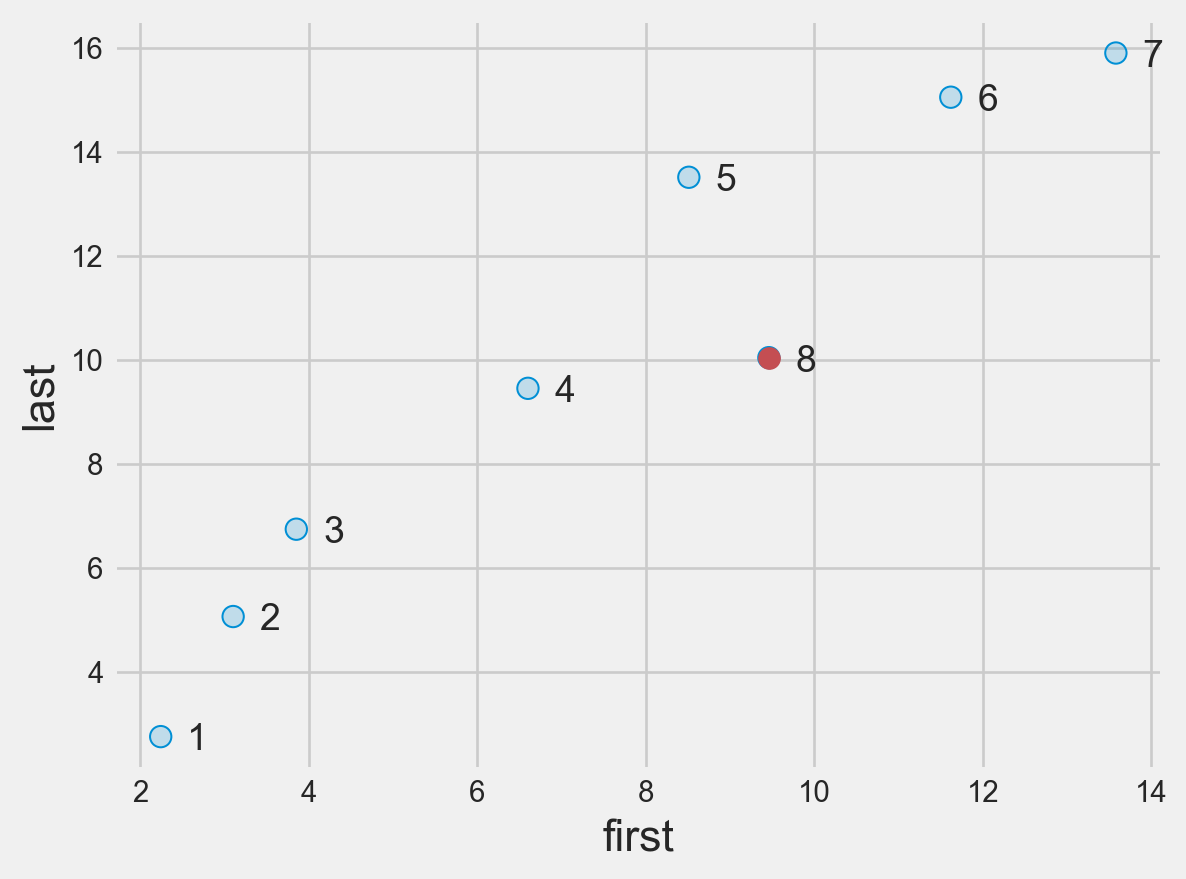

In [13]:
#| code-fold: true
def _plot_scatter_pop_out(df) -> so.Plot:
    df = (
        df
        .pivot(index='series',
               columns='episode',
               values='viewers_7day')
        .reset_index()
    )
    return (
        so.Plot(df,
                x='first',
                y='last',
                text='series')
        .add(so.Dots(pointsize=8))
        .add(so.Dot(pointsize=8, color='r'),
             data=df.query('series == "8"'))
        .add(so.Text(halign='left',
                     offset=10))
        .theme({**style.library["fivethirtyeight"]})
    )


first_last.pipe(_plot_scatter_pop_out)